# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

##Business Understanding

Q1: How many offers were recieved, viewed, and completed for each offer_type?

Q2: How client respond to offers, by sex, by income?

Q3: Predict whether a customer offer combination will be successful.

##Data Understanding

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read in the json files
portfolio = pd.read_json('/content/drive/MyDrive/Starbucks_data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/drive/MyDrive/Starbucks_data/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/drive/MyDrive/Starbucks_data/transcript.json', orient='records', lines=True)

In [ ]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [ ]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [ ]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [ ]:
# checking the distribution of offers
print("The describtions of difficulty, duration, and reward")
print(portfolio.describe())

The describtions of difficulty, duration, and reward
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


Text(0, 0.5, 'Count')

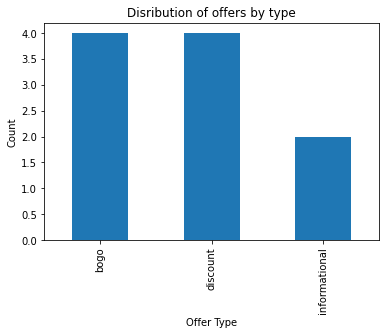

In [ ]:
portfolio['offer_type'].value_counts().plot(kind='bar')
plt.title("Disribution of offers by type")
plt.xlabel("Offer Type")
plt.ylabel("Count")

- we have a total of 10 offers in the portfolio. 4 bogo, 4 discount, and 2 informational.
- There are 4 main channels of communication.
- The difficulty varies between 0 and 20 where 0 is for informational which means that there is no minimum spend required.
- The duration varies between 3 - 10 days
- The rewards vary between 0 and 10. Where 0 is for informational

Profil dataset undestunding

In [ ]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [ ]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There is NULL values in gender (2175) and income (2175)

In [ ]:
#checking if we have any duplicated profiles
profile.duplicated().sum()

0

- total of 17000 customers in the profile dataframe.

- we will investigate:
 * Age
 * membership year from became_member_on
 * distribution of gender
 * income average

([<matplotlib.axis.XTick at 0x7fe6316ad4d0>,
 <a list of 13 Text major ticklabel objects>)

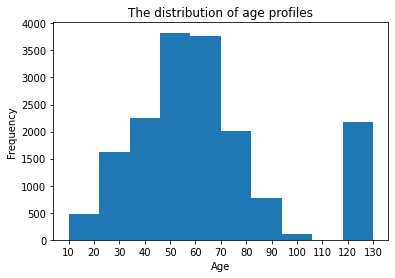

In [ ]:
#exploring the distribution of ages
profile['age'].plot(kind='hist',range=(10,130))
plt.title('The distribution of age profiles')
plt.xlabel('Age')
plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120,130])

In [ ]:
print(profile['age'].describe())

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


In [ ]:
print("number of unique profiles", profile['id'].nunique())
print("number of 118 years old profiles ", profile[profile['age']==118].age.count())

number of unique profiles 17000
number of 118 years old profiles  2175


It seems that we have an average age of 62.6 years. This is surprising to me specially that we have 2175 members that are 118 years of age. This is worth investigating further.

Text(0.5, 0, 'number of profiles')

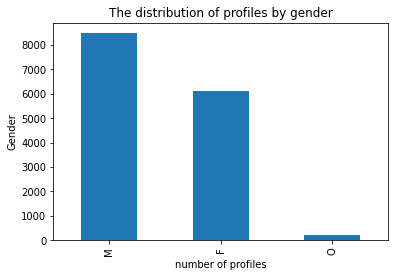

In [ ]:
# exploring gender distribution
profile['gender'].value_counts().plot(kind='bar')
plt.title("The distribution of profiles by gender")
plt.ylabel("Gender")
plt.xlabel("number of profiles")

In [ ]:
print("The number of males are: ", profile[profile['gender'] == 'M'].age.count())
print("The number of females are: ", profile[profile['gender'] == 'F'].age.count())
print("The number of others gender are: ", profile[profile['gender'] == 'O'].age.count())
print("We have a total of ", profile['gender'].isna().sum(), " that are missing gender information")

The number of males are:  8484
The number of females are:  6129
The number of others gender are:  212
We have a total of  2175  that are missing gender information


In [ ]:
# exploring if the missing gender information are the same as the 118 years of age
print("The ages for the missing gender information are :\n", profile[profile['gender'].isna()].age.value_counts())
print("The ages for the missing income information are :\n", profile[profile['gender'].isna()].income.value_counts())

The ages for the missing gender information are :
 118    2175
Name: age, dtype: int64
The ages for the missing income information are :
 Series([], Name: income, dtype: int64)


In [ ]:
profile[profile['gender'].isna()].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [ ]:
# exploring income discribution
print(profile['income'].describe())

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


Text(0, 0.5, 'Count')

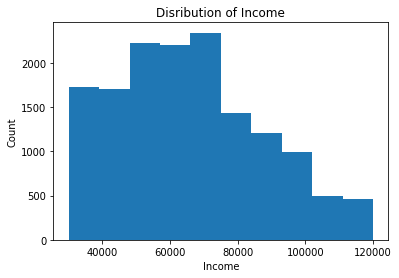

In [ ]:
profile['income'].plot(kind='hist')
plt.title("Disribution of Income")
plt.xlabel("Income")
plt.ylabel("Count")

In [ ]:
print("We have ",profile['income'].isna().sum()," missing income from the profiles")
print("The number of profiles with minimum income is :", profile[profile['income']== 30000].income.count())
print("The number of profiles with maximum income is :", profile[profile['income']== 120000].income.count())

We have  2175  missing income from the profiles
The number of profiles with minimum income is : 88
The number of profiles with maximum income is : 13


The minimum income we have is 30000 while the maximum is 120000. The average is 65404. We seem to have slightly more profiles with income more than average that profiles with income less than average.

**Transcript Dataset**

In [ ]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
#checking missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [ ]:
#exploring the events and their types
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Text(0, 0.5, 'Count')

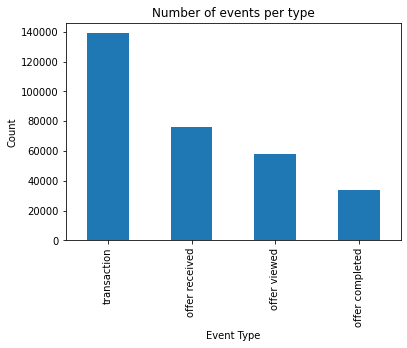

In [ ]:
transcript['event'].value_counts().plot(kind='bar')
plt.title("Number of events per type")
plt.xlabel("Event Type")
plt.ylabel("Count")

We have more transactions than any other event type. For offers, as expected, we send offers, a small portion of them is viewed and even smaller portion of them gets completed. This might not be accurate since we have informational offer that cannot be completed.
The value is different for each event type:
Transaction events include amount information
Offer recieved and offer viewed include offer id informaiton
Offer completed include offer id and reward amount information
The value column needs to be cleaned and reformatted

**Person and Time:**

In [ ]:
# checking the time destribution
print("The time desription is as follows: \n",transcript['time'].describe())

The time desription is as follows: 
 count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64


In [ ]:
# checking that we have unique people
print("The number of profiles in the person columns is ", transcript['person'].nunique())

The number of profiles in the person columns is  17000


## Data Processing

**Portfolio:**

In [ ]:
#before cleaning
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


- convert channels to be one column each
- change the duration to be hours
- change the ids to easier ids and rename to customer_id

In [ ]:
'''
Clean the portfolio dataframe and return cleaned version. The cleaninign includes:
    *converting channels to be one column each
    *changing the duration to be hours
    *changing the ids to easier ids and rename to customer_id
arguments:
    portfolio: the portfolio dataframe
output:
    portfolio: the cleaned portfolio dataframe
    new_offer_ids: the mapping of old offer ids to new offer ids


'''
def clean_portfolio_df(portfolio):
    # clean portfolio ----- to be converted to method later on.
    #change the duraiton to be hours
    portfolio['duration_hours'] = portfolio['duration'] * 24
    portfolio.drop('duration',inplace=True,axis=1)

    #conver the channels to seperate columns
    portfolio['web'] = portfolio.apply(lambda x:0  if type(x['channels'])==float else (1 if 'web' in x['channels'] else 0) ,axis=1)
    portfolio['email'] = portfolio.apply(lambda x:0  if type(x['channels'])==float else (1 if 'email' in x['channels'] else 0) ,axis=1)
    portfolio['mobile'] = portfolio.apply(lambda x:0  if type(x['channels'])==float else (1 if 'mobile' in x['channels'] else 0) ,axis=1)
    portfolio['social'] = portfolio.apply(lambda x:0  if type(x['channels'])==float else (1 if 'social' in x['channels'] else 0) ,axis=1)
    portfolio.drop('channels',axis=1,inplace=True)
    
    
    portfolio.rename(columns={'id':'offer_id'},inplace=True)


    #reorder portfolio
    portfolio = portfolio[['offer_id','offer_type','difficulty','reward','duration_hours','web','email','mobile','social']]
    
    return portfolio


portfolio = clean_portfolio_df(portfolio)

In [ ]:
portfolio

,offer_id,offer_type,difficulty,reward,duration_hours,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,168,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,120,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,96,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,168,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,240,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,168,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,240,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,72,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,120,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,168,1,1,1,0


**Profil analysis**

In [ ]:
#before cleanining
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


- change the ids to readable ids
- change ids column to customer_id
- introduce number of days since joining column
- introduce customer_type (new,regular,loyal)
- introduce year of join
- introduce age group (young_adult,middle_age_adult,old_adult)
- introduce income_range (low,mid,high)
- keep track of the new ids and old ids of the records to drop
- drop 118 years of age records

In [ ]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [ ]:
'''
Clean the profile dataframe by doing the following:
    *change the ids to readable ids
    *change ids column to customer_id
    *introduce number of days since joining column
    *introduce customer_type (new,regular,loyal)
    *introduce year of join
    *introduce age group (young_adult,middle_age_adult,old_adult)
    *introduce income_range (low,mid,high)
    *keep track of the new ids and old ids of the records to drop
    *drop 118 years of age records
arguments:
    profile: profile dataframe
output:
    profile: the cleaned profile dataframe
    deleted_customer_ids: list of deleted customers
    new_customer_ids: mapping of old customer ids to new customer ids


'''

def clean_profile_df(profile):
    #rename id
    profile.rename(columns={'id':'customer_id'},inplace=True)

    #introduce year of join
    profile['year_joined'] = profile['became_member_on'].apply(lambda x:str(x)[:4])
    # introduce number of days since join
    date_today = date.today()
    profile['days_as_member'] = profile['became_member_on'].apply(lambda x: date_today -  date(int(str(x)[:4]),
                                                                    int(str(x)[4:6]),int(str(x)[6:])))
    profile['days_as_member'] = profile['days_as_member'].apply(lambda x: x.days)
    #introduce customer type
    profile['customer_type'] = profile['days_as_member'].apply(lambda x: 'new' if x < 1095 else 
                                                               ('regular' if x < 2190 else 'loyal'))
    profile.drop('became_member_on',axis=1,inplace=True)
    # introduce age group
    profile['age_group'] = profile['age'].apply(lambda x: 'young_adult' if x < 40 else
                                                ('middle_age' if x < 60 else 'old'))
    # introduce income range
    profile['income_range'] = profile['income'].apply(lambda x: 'low' if x < 65000 else
                                                      ('mid' if x < 100000 else 'high'))
    #keep track of deleted ids 
    deleted_customer_ids = profile[profile['age'] == 118].customer_id.tolist()
    profile.drop(profile.loc[profile['age'] == 118].index,axis=0,inplace=True)

    #reorder columns 
    profile = profile[['customer_id','gender','age','age_group','income','income_range','year_joined'
                       ,'days_as_member','customer_type']]
    
    return profile,deleted_customer_ids

profile,deleted_customer_ids= clean_profile_df(profile)

In [ ]:
profile

,customer_id,gender,age,age_group,income,income_range,year_joined,days_as_member,customer_type
1,0610b486422d4921ae7d2bf64640c50b,F,55,middle_age,112000.0,high,2017,1455,regular
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,old,100000.0,high,2017,1522,regular
5,e2127556f4f64592b11af22de27a7932,M,68,old,70000.0,mid,2018,1170,regular
8,389bc3fa690240e798340f5a15918d5c,M,65,old,53000.0,low,2018,1246,regular
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,middle_age,51000.0,low,2017,1336,regular
...,...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,middle_age,54000.0,low,2018,1131,regular
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61,old,72000.0,mid,2018,1092,new
16997,01d26f638c274aa0b965d24cefe3183f,M,49,middle_age,73000.0,mid,2017,1625,regular
16998,9dc1421481194dcd9400aec7c9ae6366,F,83,old,50000.0,low,2016,1950,regular


**Transcript**

In [ ]:
#before cleanining
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0



* extract value to seperate columns (offer_id,reward,amount)
* Convert transcript time from hours to days

In [ ]:
def clean_transcript(transcript):
    
    #Extract offer_id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    
    #create two seperate columns for reward and amount
    
    for i in ['reward','amount']:
        transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)
    
    transcript.drop('value',axis=1,inplace=True)
    
    #rename customer_id
    transcript.rename(columns={'person':'customer_id'},inplace=True)
    
    #Convert transcript time from hours to days
    transcript['time'] = transcript['time'] / 24
    
    return transcript
transcript = clean_transcript(transcript)

In [ ]:
#after cleanining
transcript

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,None,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,None,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,None,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,None,NaN,3.53


In [ ]:
#Explore transcript for one person

transcript[transcript['customer_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,5.50,None,NaN,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,6.00,None,NaN,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,7.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,9.25,None,NaN,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,10.00,None,NaN,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,15.75,None,NaN,23.93


In [ ]:
def transform_transcript(transcript):
    '''
    Function to transform transcript dataframe to return a dataframe where it shows each successful and unsuccesful offer.
    
    Input - Transcript dataframe 
    
    Output - transformed transcript dataframe
     
    '''
    
    offer_customer = transcript.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    
    offer_customer.reset_index(level=[0,1],inplace = True)
    
    #Replace nan values with 0.0
    
    offer_customer.fillna(0.0, inplace = True)
    
    #Need to determine which offers where successful - where offer completed and offer viewed  are greater than 1.
    
    #We can multiply the two columns together and replace any values > 0 with 1.
    
    #This is an important step as some offers are completed but have not been viewed - meaning the offer did not cause the 
    #transaction.
    
    offer_customer['successful offer'] = offer_customer['offer completed'] * offer_customer['offer viewed']
    
    offer_customer['successful offer'] = offer_customer['successful offer'].apply(lambda x: 1.0 if x > 0 else 0.0)
    
    offer_customer.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
                                                        
                
    return offer_customer

transcript = transform_transcript(transcript)

In [ ]:
transcript

event,customer_id,offer_id,successful offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0


In [ ]:
def merge_dataframes(profile,portfolio,transcript):
    
    '''
    Function to merge all the dataframes together.
    
    Input - profile, portfolio and transcript dataframes
    
    Output - single dataframe
    
    '''
    
    overall = transcript.merge(portfolio,how='left',on='offer_id')
    
    overall = overall.merge(profile,how='left',on='customer_id')
    
    
    return overall


df_master = merge_dataframes(profile,portfolio,transcript)

df_master.head()

,customer_id,offer_id,successful offer,offer_type,difficulty,reward,duration_hours,web,email,mobile,social,gender,age,age_group,income,income_range,year_joined,days_as_member,customer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,10,2,168,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,96,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,72,0,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,120,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,10,2,240,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular


In [ ]:
df_master

,customer_id,offer_id,successful offer,offer_type,difficulty,reward,duration_hours,web,email,mobile,social,gender,age,age_group,income,income_range,year_joined,days_as_member,customer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,discount,10,2,168,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,informational,0,0,96,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,informational,0,0,72,0,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,120,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,discount,10,2,240,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1.0,bogo,5,5,120,1,1,1,1,M,34.0,young_adult,34000.0,low,2017,1628.0,regular
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,discount,20,5,240,1,1,0,0,F,45.0,middle_age,62000.0,low,2016,1687.0,regular
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1.0,discount,10,2,168,1,1,1,0,F,45.0,middle_age,62000.0,low,2016,1687.0,regular
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,bogo,5,5,168,1,1,1,0,F,45.0,middle_age,62000.0,low,2016,1687.0,regular



We now have a single dataframe which includes information about the offer and information about the customer for every combination of offers and customers.
We also determined whether an offer was successful - which was when an offer was completed and viewed by the customer.

In [ ]:
def change_offer_id(df_master):
    
    '''
    Funtion to change the offer ids into a more readable form e.g offer 1, offer 2.
    
    Input - df_master which is the combined dataframe from all 3 datasets.
    
    Output - df_master with altered offer ids.
    
    '''
    
    unique_ids = list(df_master['offer_id'].unique())
    
    for i in range(len(unique_ids)):
        
        df_master['offer_id'] = df_master['offer_id'].apply(lambda x: i if x == unique_ids[i] else x)
        
            
    return df_master
            
df_master = change_offer_id(df_master)
df_master.head()

,customer_id,offer_id,successful offer,offer_type,difficulty,reward,duration_hours,web,email,mobile,social,gender,age,age_group,income,income_range,year_joined,days_as_member,customer_type
0,0009655768c64bdeb2e877511632db8f,0,0.0,discount,10,2,168,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
1,0009655768c64bdeb2e877511632db8f,1,0.0,informational,0,0,96,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
2,0009655768c64bdeb2e877511632db8f,2,0.0,informational,0,0,72,0,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
3,0009655768c64bdeb2e877511632db8f,3,1.0,bogo,5,5,120,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
4,0009655768c64bdeb2e877511632db8f,4,1.0,discount,10,2,240,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular


## Data Analysis

**How many offers were successful for each offer_type?**

---



In [ ]:
df_master.columns

Index(['customer_id', 'offer_id', 'successful offer', 'offer_type',
       'difficulty', 'reward', 'duration_hours', 'web', 'email', 'mobile',
       'social', 'gender', 'age', 'age_group', 'income', 'income_range',
       'year_joined', 'days_as_member', 'customer_type'],
      dtype='object')

In [ ]:
# analyse how many data were received, viewed, and completed for each type
df2 = df_master[['offer_type','successful offer']]
df2 = df2.groupby('offer_type').sum()
df2

,successful offer
offer_type,
bogo,11827.0
discount,12633.0
informational,0.0


Text(0, 0.5, 'count')

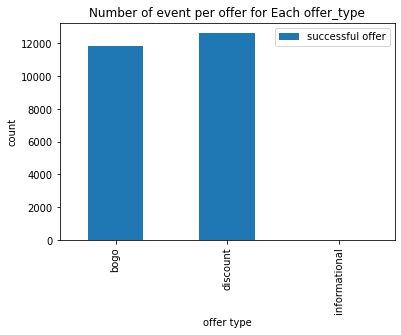

In [ ]:
df2.plot(kind='bar')
plt.title("Number of event per offer for Each offer_type")
plt.xlabel("offer type")
plt.ylabel("count")

For informational offer there is no "successful offer" because there is no call to action.
For other offer type. There is morse discount than bogo offer. 

In [ ]:
#investigate how different genders dealt reacted to offers recieved
df2 = df_master[['offer_type','gender','successful offer']]
df2 = df2[(df2['offer_type']=='bogo') & (df2['gender'] !='O')]
df2 = df2.drop('offer_type',axis=1)
df2 = df2.groupby('gender').sum()
df2

,successful offer
gender,
F,5605.0
M,5693.0


Text(0, 0.5, 'count')

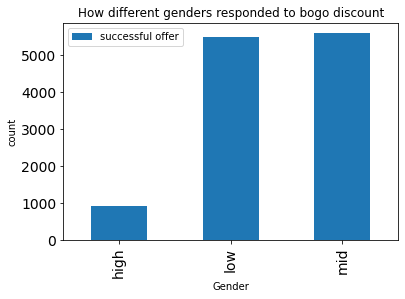

In [84]:
df2.plot(kind='bar', fontsize=14)
plt.title("How different genders responded to bogo discount")
plt.xlabel("Gender")
plt.ylabel("count")

In [ ]:
#explore how clients reacted to differnt offers - the details are based on income range
df2 = df_master[['offer_type','income_range','successful offer']]
df2 = df2[df2['offer_type'] == 'bogo']
df2 = df2.drop(['offer_type'],axis=1)
df2 = df2.groupby(['income_range']).sum()
df2

,successful offer
income_range,
high,1075.0
low,4898.0
mid,5523.0


Text(0, 0.5, 'count')

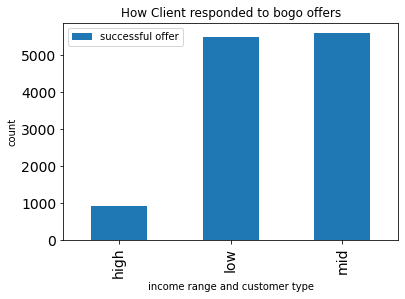

In [85]:
df2.plot(kind='bar', fontsize=14)
plt.title("How Client responded to bogo offers")
plt.xlabel("income range and customer type")
plt.ylabel("count")

In [ ]:
#explore how clients reacted to differnt offers - the details are based on income range
df2 = df_master[['offer_type','income_range','successful offer']]
df2 = df2[df2['offer_type'] == 'discount']
df2 = df2.drop(['offer_type'],axis=1)
df2 = df2.groupby(['income_range']).sum()
df2

,successful offer
income_range,
high,915.0
low,5490.0
mid,5598.0


Text(0, 0.5, 'count')

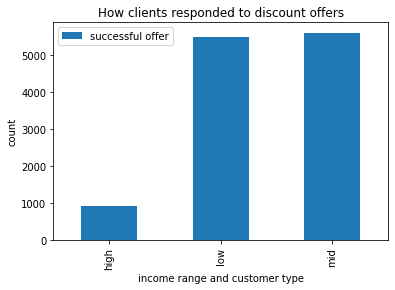

In [ ]:
df2.plot(kind='bar')
plt.title("How clients responded to discount offers")
plt.xlabel("income range and customer type")
plt.ylabel("count")

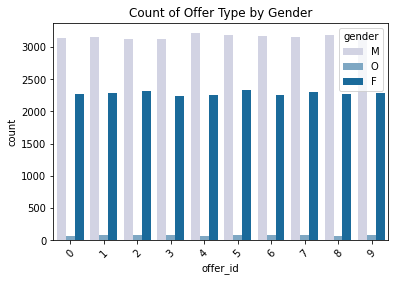

In [ ]:
sns.countplot(x='offer_id',hue='gender',data=df_master,palette='PuBu');
plt.title('Count of Offer Type by Gender')

plt.xticks(rotation=45);

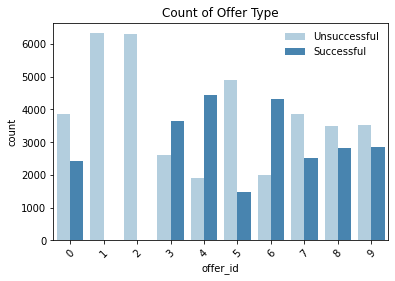

In [ ]:
sns.countplot(x='offer_id',hue='successful offer',data=df_master,palette='Blues');
plt.legend(['Unsuccessful','Successful'],frameon=False)
plt.title('Count of Offer Type')

plt.xticks(rotation=45);

##Data Modelling:

I will leave only the fields that I believe are relevant to the predication. I will also have to convert some of the fields to be in number format. 

Based on the details we have the predicted fields should be viewed and completed to tell me wether an offer would be viewed and completed or not. 

In [ ]:
df_master_backup = df_master.copy()
print(df_master.shape)
df_master.head()

(63288, 19)


,customer_id,offer_id,successful offer,offer_type,difficulty,reward,duration_hours,web,email,mobile,social,gender,age,age_group,income,income_range,year_joined,days_as_member,customer_type
0,0009655768c64bdeb2e877511632db8f,0,0.0,discount,10,2,168,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
1,0009655768c64bdeb2e877511632db8f,1,0.0,informational,0,0,96,1,1,1,0,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
2,0009655768c64bdeb2e877511632db8f,2,0.0,informational,0,0,72,0,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
3,0009655768c64bdeb2e877511632db8f,3,1.0,bogo,5,5,120,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular
4,0009655768c64bdeb2e877511632db8f,4,1.0,discount,10,2,240,1,1,1,1,M,33.0,young_adult,72000.0,mid,2017,1540.0,regular


**Predict whether a customer offer combination will be successful**

Here we are now going to predict whether a user will complete an offer based on variables from the user and on the offer.
I will be using Logistic Regression and Adaboost to try and predict whether a customer receiving an offer will be successful.
To evaluate these models i will be using the model accuracy, the f1 score. As i care equally about how the model classifies both classes i will place more of a preference on the accuracy. However, if i cared more about incorrectly classified predictions i would have chosen to focus on the f1 score. To visualize the performance of the models i will use Confusion matrixs.

In [ ]:
#drope some fields that I will not use in the modelling
df_master.drop(['age','income','customer_id','days_as_member','year_joined'],axis=1,inplace=True)

#convert gender to numbers M - 1 F -2 and O - 3
df_master['gender'] = df_master['gender'].apply(lambda x: 1 if x == 'M' else (2 if x == 'F' else 3))

#convert age groups to number format young_adult=1 middle_age=2 and old=3
df_master['age_group'] = df_master['age_group'].apply(lambda x: 1 if x == 'young_adult' 
                                                      else (2 if x == 'middle_age' else 3))
#convert income range to number format low = 1 mid=2 and high =3
df_master['income_range'] = df_master['income_range'].apply(lambda x: 1 if x == 'low' 
                                                            else (2 if x == 'mid' else 3))
#convert customer type to number format new = 1 regular =2 loyal = 3
df_master['customer_type'] = df_master['customer_type'].apply(lambda x: 1 if x == 'new' 
                                                              else (2 if x == 'regular' else 3))
#conver offer type to number format bogo = 1 discount = 2 informational =3
df_master['offer_type'] = df_master['offer_type'].apply(lambda x: 1 if x == 'bogo' 
                                                           else (2 if x == 'discount' else 3))
#scale data
scaler =StandardScaler()
features = ['offer_id','offer_type','income_range','customer_type','duration_hours', 'reward', 'difficulty']
df_master[features] = scaler.fit_transform(df_master[features])
df_master.head()

,offer_id,successful offer,offer_type,difficulty,reward,duration_hours,web,email,mobile,social,gender,age_group,income_range,customer_type
0,-1.569960,0.0,0.267545,0.412967,-0.648341,0.224720,1,1,1,0,1,1,0.341082,-0.433144
1,-1.221813,0.0,1.603960,-1.391620,-1.236077,-1.136721,1,1,1,0,1,1,0.341082,-0.433144
2,-0.873667,0.0,1.603960,-1.391620,-1.236077,-1.590535,0,1,1,1,1,1,0.341082,-0.433144
3,-0.525520,1.0,-1.068870,-0.489327,0.233263,-0.682908,1,1,1,1,1,1,0.341082,-0.433144
4,-0.177374,1.0,0.267545,0.412967,-0.648341,1.586161,1,1,1,1,1,1,0.341082,-0.433144


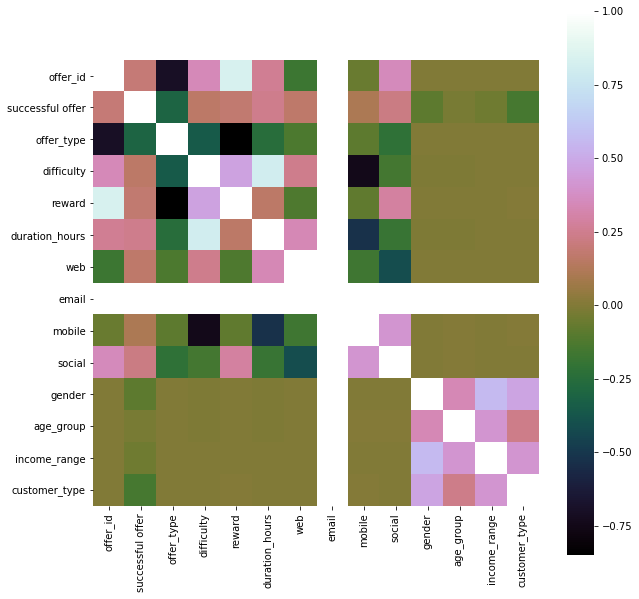

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df_master.corr(),square=True, cmap='cubehelix');

In [ ]:
#drope email field
df_master.drop(['email'],axis=1,inplace=True)

In [ ]:
df_master.columns

Index(['offer_id', 'successful offer', 'offer_type', 'difficulty', 'reward',
       'duration_hours', 'web', 'mobile', 'social', 'gender', 'age_group',
       'income_range', 'customer_type'],
      dtype='object')

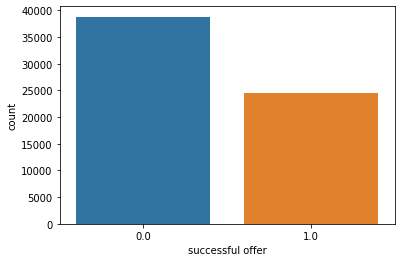

In [ ]:
sns.countplot(df_master['successful offer']);

In [ ]:
#prepare the x values for the prediction model
x = df_master.drop(['successful offer'],axis=1)
#defind the values to be predicted
y = df_master[['successful offer']]
#split the values to training and testing 
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

#logistic regression

In [ ]:
model = LogisticRegression(solver='liblinear',random_state=42)

In [ ]:
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_pred = model.predict(x_test)

In [ ]:
log_accuracy = accuracy_score(y_test,log_pred)

print("Logistic Regression Accuracy: %.2f" % accuracy_score(y_test, log_pred))

Logistic Regression Accuracy: 0.72


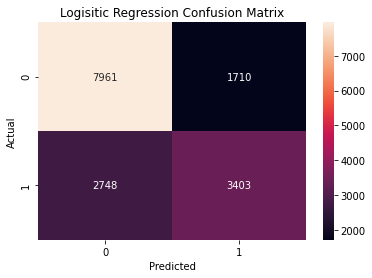

In [ ]:
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='d')
plt.title('Logisitic Regression Confusion Matrix')
plt.ylabel("Actual")
plt.xlabel("Predicted");

In [ ]:
log_f1_score = f1_score(y_test,log_pred)

print('Logisitic Regression F1 Score: %.3f' % log_f1_score)

Logisitic Regression F1 Score: 0.604


In [ ]:
parameters = {'penalty': ['l1','l2'], 'C': [1,10,100,1000]}

grid_log = GridSearchCV(LogisticRegression(), parameters, verbose=3, n_jobs=-1,cv=3)

In [ ]:
grid_log.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid_log.best_params_

{'C': 10, 'penalty': 'l2'}

In [ ]:
log2_pred = grid_log.predict(x_test)

In [ ]:
log2_accuracy = accuracy_score(y_test,log2_pred)
log2_f1 = f1_score(y_test,log2_pred)
print('Tuned Logistic Regression accuracy: %.3f' % log2_accuracy)
print('Tuned Logistic Regression F1 score: %.3f' % log2_f1)

Tuned Logistic Regression accuracy: 0.721
Tuned Logistic Regression F1 score: 0.610


Our original Logistic Regresion model achieved the exact same f1 score but achieved a slightly higher accuracy. So using GridSearch our model did not improve.
Typically Logistic Regression requires large samples sizes for accurate results.

**Adaboost Classifier**

In [ ]:
parameters = {'n_estimators':[500, 1000, 1500, 2000], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

In [73]:
ada = AdaBoostClassifier()

clf = GridSearchCV(ada,parameters,cv=3,verbose=3,n_jobs=-1)

clf.fit(x_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 14.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [500, 1000, 1500, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [74]:
clf.best_params_

{'learning_rate': 0.05, 'n_estimators': 2000}

In [75]:
ada_pred = clf.predict(x_test)
ada_accuracy = accuracy_score(y_test,ada_pred)
ada_f1 = f1_score(y_test, ada_pred)

print("ADA Model Accuracy: %.3f" % ada_accuracy)
print("ADA Model F1 Accuracy: %.3f" % ada_f1)

ADA Model Accuracy: 0.752
ADA Model F1 Accuracy: 0.679


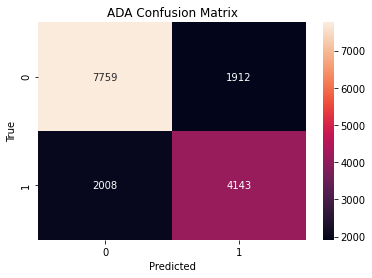

In [76]:
sns.heatmap(confusion_matrix(y_test,ada_pred),annot=True,fmt='d')
plt.title("ADA Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True');

In [77]:
print(classification_report(y_test,ada_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      9671
         1.0       0.68      0.67      0.68      6151

    accuracy                           0.75     15822
   macro avg       0.74      0.74      0.74     15822
weighted avg       0.75      0.75      0.75     15822



In [78]:
'''
prints the classification report for the predicted value vs test value.
arguments:
    classification_name: name of the classifier
    y_pred: the predicted value
    y_test: the test value

'''
def print_scoring_report(classification_name,y_pred,y_test):
    labels = ['successful offer']
    y_test2 = np.array(y_test)
    y_pred2 = np.array(y_pred)
    class_dict={}

    for label in range(len(labels)):
        y_test_label = y_test2[:, label]
        y_pred_label = y_pred2[:, label]
        class_dict[labels[label]] = classification_report(y_pred=y_pred_label, y_true=y_test_label)
        print("The accuracy for label {} using {} is: {}".format(labels[label],classification_name,
                                                                    accuracy_score(y_test_label,y_pred_label)))

        
    for label, matrix in class_dict.items():
        print("Classificaiton report for label {} using {}:".format(label,classification_name))
        print(matrix)

In [79]:
'''
create a multioutput classifier and then fit it and predict the y value.
finally print the score of the classifier.
arguments:
    classifier_type: pass the classifier that you are using in the multioutput classifier
output:
    y_pred: the predicted y value

'''
def predict_values(classifier_type):
    classifier = MultiOutputClassifier(estimator=classifier_type,n_jobs=-1)
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    print("The score of the classifier is ", classifier.score(x_test,y_test))
    print("The score of the classifier on training data is ", classifier.score(x_train,y_train))
    return y_pred



##Conclusion

<p> The biggest challenge of this project was to do the correct data cleaning and understand the best way to define a successful offer. Separating the offers to identify 100% of the cases that actually followed the expected pattern for success previously defined is quite complex, especially in the way in which the data are arranged. </p>


<p> By analyzing the correlation matrix more deeply, we can identify that the Social and Mobile channels were most related with offers visualization than others channels. Therefore, it is recommended that the company focus more on then in future campaigns.</p>

<p> Moving to the classification models, the focus was on evaluating which of the proposed models would present the best solution. Here is a comparison between our models based on accuracy</p>

In [80]:
accuracy = np.array([log_accuracy,log2_accuracy,ada_accuracy]).reshape(-1,1)
f1_score = np.array([log_f1_score,log2_f1,ada_f1]).reshape(-1,1)

metrics = pd.DataFrame(np.concatenate((accuracy,f1_score),axis=1),columns=['Accuracy','F1 Score'])

model_names = np.array(['Logistic Regresson 1','Logistic Regression 2','ADA']).reshape(-1,1)

metrics = pd.concat([metrics,pd.DataFrame(model_names)],axis=1)

metrics.columns = ['Accuracy','F1 Score','Model Names']

metrics.set_index('Model Names').sort_values(by='Accuracy',ascending=False)

,Accuracy,F1 Score
Model Names,,
ADA,0.752244,0.678846
Logistic Regression 2,0.721401,0.609566
Logistic Regresson 1,0.718240,0.604226


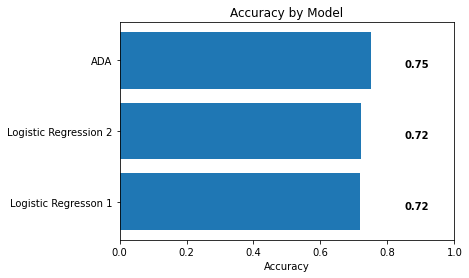

In [81]:
plt.barh(metrics['Model Names'],metrics['Accuracy']);
plt.xlabel('Accuracy')
plt.title('Accuracy by Model')
plt.xlim([0,1])


labels = ['%.2f' % x for x in metrics['Accuracy']]


for i,v in enumerate(metrics['Accuracy']):
    plt.gca().text(0.85, i - 0.1, labels[i], color='black', fontweight='bold')

We can see that we got better results using ADAboost algorithm.

## **Some improvements**
<p> 
I believe that with more demographic information from clients, such as - city, profession or feedback, it would be possible to propose better strategies and find better results. In addition, the classification models could have benefited from more user transactions in the database.</p>
<p>Also it would be good to check and improve the sucess/unsucess formula used for bogo and discount offers with a more robust method and include the informational offers by seeting clear metrics for them.</p>
